In [8]:
import numpy as np
import xarray as xr
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path

from preprocessing import preprocess_ecmwf, preprocess_target, preprocess_raw_forecasts

## Description of forecast data
In "/data/volume_2/subseasonal/ecmwf/" we have stored extended range forecast data from the ecmwf center. This is a sub-set of the S2S database, a subset that was published as part of the S2S-AI competition https://s2s-ai-challenge.github.io/ 

The data is separated in 20 years of hindcasts (a.k.a. re-forecasts) with 11 members (2000-2019), and one year of operational forecasts with 51 members (2020).

Our target is 4-week accumulated rainfall in the Horn of Africa, forecast at a sub-seasonal lead time of 2 weeks. This means we evaluate the predictions over week 3+4+5+6. We have selected those weeks, and pre-aggregated all data for you, script: 'aggregation.py', data directory: "/data/volume_2/subseasonal/ecmwf/aggregated/". This gridded data is global, at a resolution of 1.5x1.5 degrees. Multiple variables are present:

In [4]:
list(Path('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/').glob('*.nc'))

[PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-gh-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-tcw-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-t2m-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sm20-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sm100-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sst-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-tp-week3456.nc')]

Among these are:
* 'total precipitation' (tp) of course
* but also 'total column water' (tcw)
* 'geopotential at 500 hPa' (gh)
* 'two-meter-temperature' (t2m)
* 'soil moisture 0-20 cm' (sm20)
* 'soil moisture 0-100 cm' (sm100)
* 'sea surface temperature' (sst). 

Further details in the attributes and here: https://confluence.ecmwf.int/display/S2S/Parameters  

A pre-aggregated (still gridded) target variable from CHRIPS is available in two spatial resolutions:

In [5]:
list(Path('/data/volume_2/observational/preprocessed/').glob('*4week*.nc'))

[PosixPath('/data/volume_2/observational/preprocessed/chirps_tp_2000-2020_4weekly_0.25deg_africa.nc')]

## Pre-processing data for the CNN
The current application takes in gridded patches centered over the Horn of Africa and predicts a scaler or categorical variable. The stack of patches can comprise multiple forecasted variables from ecmwf (like precipitation and temperature), all of the ensemble members, or summery statistics like the ensemble mean.
These multiple variable cannot be fed directly, but need to be standardized and put on the same scale. This is what pre-processing does. Several choices need to be made (and can be experimented with):
* removing the seasonal cycle?
* which variables to include?
* ensemble mean or members, or ...?
* standardize per grid point over time (i.e. remove climatological gradients) or standardize patch over space, per moment in time?

Also for the target choices need to be made:
* Over which masked spatial region do I average?
* What quantiles do I use for categorizing it?

In [16]:
scratchdir = Path('/scratch/')
experiment_name = 'trial2_ensmean'
ensmean = True
varlist = ['tp','sst','tcw']

# Construction of Patched inputs
training_inputs = {key:[] for key in varlist}  # These will be hindcasts
testing_inputs = {key:[] for key in varlist}  # These will be forecasts (though probably more testing data will be generated through crossvalidation of hindcasts)
for var in varlist:
    if var == 'tp': # No seasonal anomalies
        hindcast, forecast = preprocess_ecmwf(var = var, rm_season = False, ensmean = ensmean, standardize_space = False, standardize_time = True) # No seasonal removal for rainfall? Perhaps rainfall should be min-max scaled, such that zero is really zero?
    else:
        hindcast, forecast = preprocess_ecmwf(var = var, rm_season = True, ensmean = ensmean, standardize_space = False, standardize_time = True)
    training_inputs[var] = hindcast.expand_dims({'variable':[var]})
    testing_inputs[var] = forecast.expand_dims({'variable':[var]})

training_inputs = xr.concat(training_inputs.values(), dim = 'variable') # This already stacks the arrays into nchannels = nvariables 
testing_inputs = xr.concat(testing_inputs.values(), dim = 'variable')

# If not ensmean then extra stacking of channels, as multiple members available per variable
if not ensmean:
    nmembers = len(training_inputs.coords['realization'])
    training_inputs = training_inputs.stack({'channels':['realization','variable']})
    testing_inputs = testing_inputs.sel(realization = np.random.choice(testing_inputs.realization.values, size = nmembers, replace = False)) # Testing now needs to be matched in training, so downsampling the members to 11 (always select control?)
    testing_inputs = testing_inputs.stack({'channels':['realization','variable']})
else:
    training_inputs = training_inputs.rename({'variable':'channels'})
    testing_inputs = testing_inputs.rename({'variable':'channels'})

# processing target (one-hot encoded)
quantile_edges = [0.33,0.66]
maskname = 'era5_hoa_dry_mask_0.25deg.nc'
target_h, target_f, chirps_edges = preprocess_target(maskname = maskname, quantile_edges = quantile_edges, return_edges = True)
# Extracting benchmark forecasts for the categorized spatial average (no input to the CNN, but to be used as 'raw' benchmark) 
hindcast_benchmark, forecast_benchmark, ecmwf_edges = preprocess_raw_forecasts(maskname = maskname, quantile_edges = quantile_edges, return_edges = True)

attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
standardization is temporal
computing standard scaler on (1060, 729), members as samples = False
standardization is temporal
using pre-trained standard scaler on (53, 729), members as samples = False
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
computing seasonality of individual members, members treated as extra samples for the climate
seasonal expectation is presupplied
standardization is temporal
computing standard scaler on (1060, 729), members as samples = False
standardization is temporal
using pre-trained standard scaler on (53, 729), members as samples = False
attempt patch selection lat:slice(24.511, -15.489, None), lon:

In [17]:
"""
Writing the choices of the experiment to disk (under experiment_name)
"""
# Re-ordering and writing inputs to disk (only array, no coordinates, so directly readable with numpy (and tensorflow)
# (nsamples,nlat,nlon,nchannels)
np.save(file = scratchdir / f'{experiment_name}.training_inputs.npy', arr = training_inputs.transpose('valid_time','latitude','longitude','channels').values)
np.save(file = scratchdir / f'{experiment_name}.testing_inputs.npy', arr = testing_inputs.transpose('valid_time','latitude','longitude','channels').values)

# writing targets to disk (nsamples, nclasses)
np.save(file = scratchdir / f'{experiment_name}.training_terciles.npy', arr = target_h.values)
np.save(file = scratchdir / f'{experiment_name}.testing_terciles.npy', arr = target_f.values)

# Writing benchmarks to disk (nsamples, nclasses), not as numpy but as pandas because no feeding into neural network
hindcast_benchmark.to_pandas().to_hdf(scratchdir / f'{experiment_name}.training_benchmark.h5', key = 'benchmark', mode = 'w')
forecast_benchmark.to_pandas().to_hdf(scratchdir / f'{experiment_name}.testing_benchmark.h5', key = 'benchmark', mode = 'w')

# Some extra time information
target_h.valid_time.to_pandas().to_hdf(scratchdir / f'{experiment_name}.training_timestamps.h5', key = 'timestamps', mode = 'w')
target_f.valid_time.to_pandas().to_hdf(scratchdir / f'{experiment_name}.testing_timestamps.h5', key = 'timestamps', mode = 'w')

<AxesSubplot:xlabel='month'>

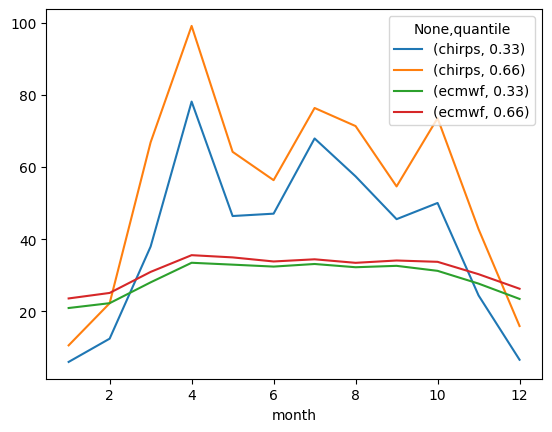

In [18]:
pd.concat([chirps_edges.to_pandas(),ecmwf_edges.to_pandas()], axis = 1, keys = ['chirps','ecmwf']).plot()

## CNN training
reading the input from disk again

In [20]:
15 * 0.5 * 10

75.0